In [2]:
#!pip install --upgrade pip
!pip install pyathena

  Using cached pyathena-3.3.0-py3-none-any.whl.metadata (86 kB)
  Using cached urllib3-2.0.7-py3-none-any.whl.metadata (6.6 kB)
Using cached pyathena-3.3.0-py3-none-any.whl (80 kB)
Using cached urllib3-2.0.7-py3-none-any.whl (124 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.1.0
    Uninstalling urllib3-2.1.0:
      Successfully uninstalled urllib3-2.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2022.7.0 requires tornado<6.2,>=6.0.3, but you have tornado 6.4 which is incompatible.
sagemaker 2.199.0 requires urllib3<1.27, but you have urllib3 2.0.7 which is incompatible.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
#Upgrade de la version de seaborn para poder hacer graficos mas facil 
!pip install seaborn==0.12.2

  Using cached seaborn-0.12.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [4]:
#Libraries
from pyathena import connect
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing


In [5]:
# DB Setting
bucket_name = 's3://viamericas-datalake-dev-us-east-1-283731589572-athena/'
origin_name = 'AwsDataCatalog'
database_name = 'analytics'
tablaSource = 'source_fraud_fechas_label'


In [27]:
#Connection

conn = connect(s3_staging_dir=f'{bucket_name}queryresults/',
               region_name='us-east-1')
date_to_compare1 = '2023-01-01'
date_to_compare2 = '2023-05-01'

df_source = pd.read_sql('''SELECT * FROM analytics.source_fraud_fechas_label 
            where date_receiver_clean between cast('2023-01-01'  as date) and cast('2023-02-01'  as date);''', conn)


/tmp/ipykernel_18/517809514.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_source = pd.read_sql('''SELECT * FROM analytics.source_fraud_fechas_label


In [26]:
df_source2 = pd.read_sql('''SELECT * FROM analytics.source_fraud_fechas_label 
             where date_receiver_clean between cast('2023-01-01'  as date) and cast('2023-01-15'  as date);''', conn)


/tmp/ipykernel_18/2786907795.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_source2 = pd.read_sql('''SELECT * FROM analytics.source_fraud_fechas_label


In [28]:
df_source.head()

,id_branch,id_receiver,date_receiver,hour_receiver,day_name_receiver,net_amount_receiver,id_payout,was_fraud,was_fraud_pattern,was_ofac_receiver_hit,...,id_payer,id_sender_global,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_to_last_transaction,day,date_receiver2,id_sender2,fraud_type,date_receiver_clean
0,A18386,106651,2023-01-25 19:44:38.970000000,19,Wednesday,140.0,P,0,0,0,...,T232,7808484,46168,4,287,2023-01-25,2023-01-25 19:44:38.970,6229.0,None,2023-01-25
1,A08812,76271,2023-01-25 09:13:36.180000000,09,Wednesday,100.0,P,0,0,0,...,T085,2265946,5467,4,338,2023-01-25,2023-01-25 09:13:36.180,533.0,None,2023-01-25
2,A15234,38786,2023-01-25 08:51:37.177000000,08,Wednesday,240.0,P,0,0,0,...,T061,9582768,2841,771,329,2023-01-25,2023-01-25 08:51:37.177,2776.0,None,2023-01-25
3,A11490,303397,2023-01-25 08:36:50.360000000,08,Wednesday,183.0,C,0,0,0,...,T229,5444963,9880,1,310,2023-01-25,2023-01-25 08:36:50.360,17718.0,None,2023-01-25
4,A05998,94138,2023-01-25 10:34:14.280000000,10,Wednesday,170.0,P,0,0,0,...,T232,3280602,8649,66,301,2023-01-25,2023-01-25 10:34:14.280,10603.0,None,2023-01-25


In [32]:
df_source['mes'] = df_source['date_receiver_clean'].dt.month
df_source['fraud_type'] = df_source['fraud_type'].str.capitalize()

## Creo las nuevas variables
### sender_days_to_last_transaction_365 y sender_days_to_last_transaction_more365
### sender_minutes_since_last_transaction_2days
### net_amount_receiver?

In [9]:
#defino corte en funcion deñ percenti
df_source['sender_days_to_last_transaction'].describe()

count    122302.000000
mean        267.426142
std         121.356855
min           0.000000
25%         206.000000
50%         335.000000
75%         355.000000
max         364.000000
Name: sender_days_to_last_transaction, dtype: float64

In [10]:
#defino dos nuevas variables a partir de la anterior
df_source['sender_days_to_last_transaction_365'] = df_source['sender_days_to_last_transaction']
df_source['sender_days_to_last_transaction_more365'] = 0
#corto en un maximo de dias y el resto lo pongo enlas variables nuevas
df_source.sender_days_to_last_transaction_more365[df_source['sender_days_to_last_transaction']> 365] = 1
df_source.sender_days_to_last_transaction_365[df_source['sender_days_to_last_transaction']> 365] = 0 

/tmp/ipykernel_18/461507757.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_source.sender_days_to_last_transaction_more365[df_source['sender_days_to_last_transaction']> 365] = 1
/tmp/ipykernel_18/461507757.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_source.sender_days_to_last_transaction_365[df_source['sender_days_to_last_transaction']> 365] = 0


In [11]:
#defino dos nuevas variables a partir de la anterior
df_source['sender_minutes_since_last_transaction_2days'] = df_source['sender_minutes_since_last_transaction']
df_source['sender_minutes_since_last_transaction_1day'] = df_source['sender_minutes_since_last_transaction']
#corto en un maximo de dias y el resto lo pongo enlas variables nuevas
df_source.sender_minutes_since_last_transaction_2days[df_source['sender_minutes_since_last_transaction']> 2*24*60] = 0
df_source.sender_minutes_since_last_transaction_1day[df_source['sender_minutes_since_last_transaction']> 24*60] = 0

/tmp/ipykernel_18/2804084275.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_source.sender_minutes_since_last_transaction_2days[df_source['sender_minutes_since_last_transaction']> 2*24*60] = 0
/tmp/ipykernel_18/2804084275.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_source.sender_minutes_since_last_transaction_1day[df_source['sender_minutes_since_last_transaction']> 24*60] = 0


## Estandarizo variables
### sender_days_to_last_transaction_365, sender_minutes_since_last_transaction_2days, net_amount_receiver, sender_sending_days, branch_working_days, receiver_transaction_count

In [12]:
df_source['receiver_transaction_count'].describe()

count    122302.000000
mean         17.686424
std          23.516598
min           1.000000
25%           3.000000
50%           9.000000
75%          24.000000
max         666.000000
Name: receiver_transaction_count, dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

<AxesSubplot:xlabel='01_receiver_transaction_count', ylabel='Count'>

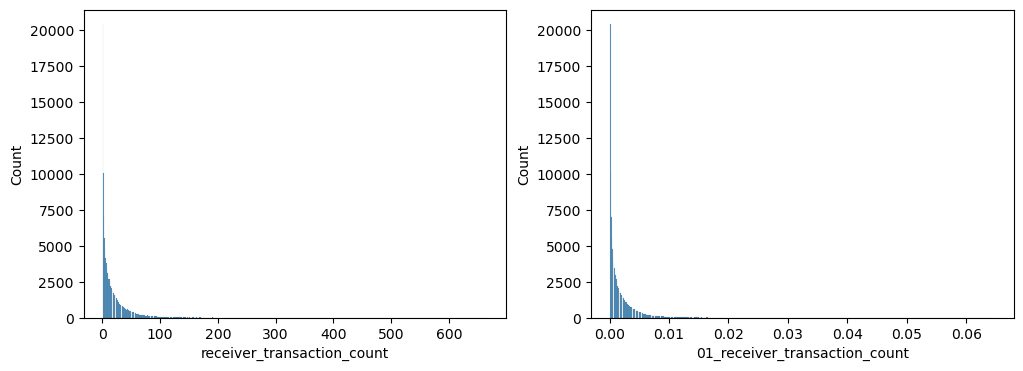

In [13]:
df_source['01_receiver_transaction_count']  = preprocessing.normalize([df_source['receiver_transaction_count']]).T

M = df_source['receiver_transaction_count'] .max()
m = M = df_source['receiver_transaction_count'] .min()

#df_source['01_receiver_transaction_count'] = (df_source['receiver_transaction_count'] -m)/(M-m)

#scaler = preprocessing.MinMaxScaler(feature_range =(0,1))
#d = scaler.fit_transform([df_source['receiver_transaction_count']])
#print(d)
#df_source['01_receiver_transaction_count']  = d.T

fig, axs = plt.subplots(1,2,figsize = (12, 4))
sns.histplot(data=df_source, x="receiver_transaction_count", ax = axs[0])
sns.histplot(data=df_source, x="01_receiver_transaction_count", ax = axs[1])


In [14]:
df_source['sender_sending_days'].describe()

count    122302.000000
mean        228.950238
std         133.267505
min           0.000000
25%         104.000000
50%         279.000000
75%         353.000000
max         367.000000
Name: sender_sending_days, dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

<AxesSubplot:xlabel='01_sender_sending_days', ylabel='Count'>

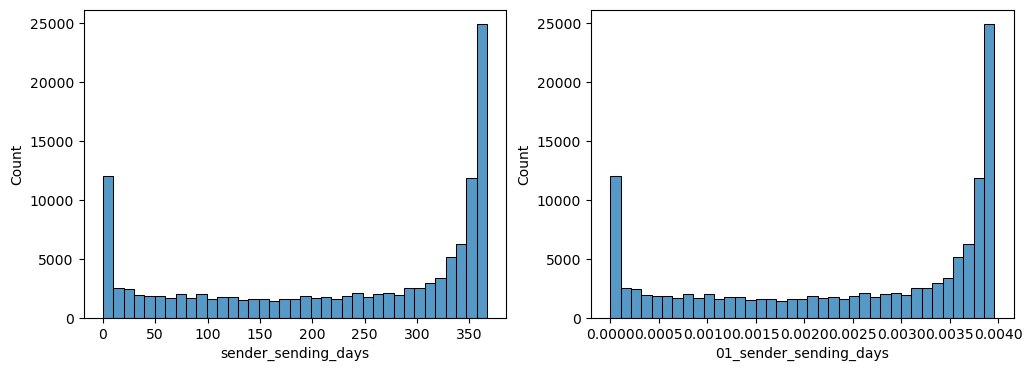

In [15]:
df_source['01_sender_sending_days']  = preprocessing.normalize([df_source['sender_sending_days']]).T

fig, axs = plt.subplots(1,2,figsize = (12, 4))
sns.histplot(data=df_source, x="sender_sending_days", ax = axs[0])
sns.histplot(data=df_source, x="01_sender_sending_days", ax = axs[1])

In [16]:
df_source['branch_working_days'].describe()

count    122302.000000
mean       1627.772432
std        1410.548705
min           0.000000
25%         589.000000
50%        1151.000000
75%        2302.000000
max        6538.000000
Name: branch_working_days, dtype: float64

In [17]:
df_source['net_amount_receiver'].describe()

count    122302.000000
mean        488.680338
std         612.630731
min           1.000000
25%         104.000000
50%         250.000000
75%         600.000000
max        7990.000000
Name: net_amount_receiver, dtype: float64

In [18]:
df_source['sender_minutes_since_last_transaction_2days'].describe()

count    122302.000000
mean         70.006132
std         368.571829
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        2880.000000
Name: sender_minutes_since_last_transaction_2days, dtype: float64

In [19]:
df_source['sender_minutes_since_last_transaction_1day'].describe()

count    122302.000000
mean         16.325857
std         135.405748
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1440.000000
Name: sender_minutes_since_last_transaction_1day, dtype: float64

In [20]:
df_source['sender_days_to_last_transaction_365'].describe()

count    122302.000000
mean        267.426142
std         121.356855
min           0.000000
25%         206.000000
50%         335.000000
75%         355.000000
max         364.000000
Name: sender_days_to_last_transaction_365, dtype: float64

In [21]:
df_source['branch_minutes_since_last_transaction'].describe()

count    122302.000000
mean        157.294484
std         719.285721
min           0.000000
25%           4.000000
50%          13.000000
75%          43.000000
max       49958.000000
Name: branch_minutes_since_last_transaction, dtype: float64

In [22]:
# Normalizo a lo bruto. Dsp reviso el algoritmo
df_source['01_receiver_transaction_count'] = preprocessing.normalize([df_source['sender_sending_days']]).T
df_source['01_sender_sending_days'] = preprocessing.normalize([df_source['sender_sending_days']]).T
df_source['01_branch_working_days'] = preprocessing.normalize([df_source['branch_working_days']]).T
df_source['01_net_amount_receiver'] = preprocessing.normalize([df_source['net_amount_receiver']]).T
df_source['01_sender_minutes_since_last_transaction_2days'] = preprocessing.normalize([df_source['sender_minutes_since_last_transaction']]).T
df_source['01_sender_minutes_since_last_transaction_1day'] = preprocessing.normalize([df_source['sender_minutes_since_last_transaction']]).T
df_source['01_sender_days_to_last_transaction_365'] = preprocessing.normalize([df_source['sender_days_to_last_transaction']]).T

In [23]:

df_source['01_receiver_transaction_count'].describe()
df_source['01_sender_sending_days'].describe()
df_source['01_branch_working_days'].describe()
df_source['01_net_amount_receiver'].describe()
df_source['01_sender_minutes_since_last_transaction_2days'].describe()
df_source['01_sender_minutes_since_last_transaction_1day'].describe()
df_source['01_sender_days_to_last_transaction_365'].describe()

count    122302.000000
mean          0.002604
std           0.001182
min           0.000000
25%           0.002006
50%           0.003262
75%           0.003457
max           0.003544
Name: 01_sender_days_to_last_transaction_365, dtype: float64

## Creacion del target

In [31]:
df_source['fraud_type'].value_counts()

fraud_type
REMOTE ACCESS    55
PAYMENT          35
MONEY ORDER       2
Red Phone         1
Name: count, dtype: int64

In [39]:
# defino los targets
df_source['target1'] = df_source['fraud_type'] == 'Remote access'
df_source['target2'] = df_source['fraud_type'] == 'Payment'
df_source['target_fraudes'] = df_source['fraud_type'].notnull()


In [37]:
df_source['target1'].value_counts()

target1
False    1759522
True          55
Name: count, dtype: int64

In [38]:
df_source['target2'].value_counts()

target2
False    1759542
True          35
Name: count, dtype: int64

In [41]:
df_source['target_fraudes'].value_counts()

target_fraudes
False    1759484
True          93
Name: count, dtype: int64

## Guardo archivos para dsp juntar en el entrenamiento

In [44]:
#Me quedo con las variables q voy a usar
df_source.columns.values
df_source ['id_branch', 'id_receiver', 'hour_receiver','day_name_receiver','net_amount_receiver','was_ofac_receiver_hit','was_ofac_sender_hit',
          'receiver_transaction_count','branch_working_days','sender_sending_days','branch_minutes_since_last_transaction','sender_days_to_last_transaction',
           '01_receiver_transaction_count','01_sender_sending_days','01_branch_working_days','01_net_amount_receiver',''
           'fraud_type','date_receiver_clean','target1','target2','target_fraudes']

##'sender_days_since_last_transaction','sender_minutes_since_last_transaction'

array(['id_branch', 'id_receiver', 'date_receiver', 'hour_receiver',
       'day_name_receiver', 'net_amount_receiver', 'id_payout',
       'was_fraud', 'was_fraud_pattern', 'was_ofac_receiver_hit',
       'was_ofac_sender_hit', 'receiver_transaction_count',
       'id_country_receiver_claim', 'id_city', 'id_state', 'id_location',
       'branch_working_days', 'sender_sending_days',
       'sender_days_since_last_transaction', 'id_payer',
       'id_sender_global', 'sender_minutes_since_last_transaction',
       'branch_minutes_since_last_transaction',
       'sender_days_to_last_transaction', 'day', 'date_receiver2',
       'id_sender2', 'fraud_type', 'date_receiver_clean', 'mes',
       'target1', 'target2', 'target_fraudes'], dtype=object)

In [42]:
import os
import pyarrow as pa
import pyarrow.parquet as pq

In [43]:
def guardar_dataset_con_valor_parquet(df, columna_nombre='week_dt', nombre_archivo='dataset', carpeta='ABT'):
    """
    Guarda un DataFrame en un archivo Parquet con un nombre basado en el valor de una columna,
    dentro de una carpeta especificada.

    Parameters:
    - df: DataFrame que se va a guardar.
    - columna_nombre: Nombre de la columna cuyo valor se utilizará en el nombre del archivo.
    - nombre_archivo: Nombre base del archivo Parquet (sin la extensión).
    - carpeta: Nombre de la carpeta donde se guardarán los archivos Parquet.

    Returns:
    - Ruta del archivo guardado.
    """
    # Ensure that the folder exists or create it.
    # Asegurarse de que la carpeta exista o crearla
    if not os.path.exists(carpeta):
        os.makedirs(carpeta)

    # Ensure the column exists
    # Asegurarse de que la columna existe
    if columna_nombre not in df.columns:
        raise ValueError(f"La columna '{columna_nombre}' no existe en el DataFrame.")

    # Get the value of the first row in the column
    # Obtener el valor de la primera fila de la columna
    valor_primera_fila = df[columna_nombre].iloc[0]

    # Create the full file path with the column value and .parquet extension
    # Crear la ruta completa del archivo con el valor de la columna y la extensión .parquet
    ruta_archivo_valor = os.path.join(carpeta, f"{nombre_archivo}_{valor_primera_fila}.parquet")

    # Save the DataFrame to a Parquet file
    # Guardar el DataFrame en un archivo Parquet
    table = pa.Table.from_pandas(df)
    pq.write_table(table, ruta_archivo_valor)

    return ruta_archivo_valor

# Fill missing values with zeros in numeric columns
## Completa los valores faltantes con ceros de las columnas numericas

In [ ]:
guardar_dataset_con_valor_parquet(df_source, columna_nombre='mes', nombre_archivo='Prepoc_Fraude',carpeta='ABT') # save ABT in parquet format